ΑΛΛΑΞΑ ΚΆΠΟΙΑ ΠΡΑΓΜΑΤΑ ΣΤΟ section Feature engineering (kurtosis+skewness). ΘΑ ΨΑΞΩ ΚΑΙ ΓΙΑ ΑΛΛΑ FEATURES ΚΑΙ ΘΑ ΤΑ ΒΑΛΩ

# Clone repository from github

In [ ]:
# Load the data on the server session
!git clone https://github.com/RealThanosP/pred-main-mod

# Change your working directory inside the repository
%cd pred-main-mod

Cloning into 'pred-main-mod'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 120 (delta 63), reused 2 (delta 0), pack-reused 28 (from 2)
Receiving objects: 100% (120/120), 85.54 MiB | 12.11 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Updating files: 100% (26/26), done.
/content/pred-main-mod/pred-main-mod


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import os
import seaborn as sns

#Getting the sensor files in a list

In [ ]:
folder_path = "data/condition+monitoring+of+hydraulic+systems"

# Define the list of sensors and their corresponding column names
sensors = [
    "PS1", "PS2", "PS3", "PS4", "PS5", "PS6",  # Pressure sensors
    "EPS1",  # Motor power
    "FS1", "FS2",  # Volume flow
    "TS1", "TS2", "TS3", "TS4",  # Temperature sensors
    "VS1",  # Vibration
    "CE",  # Cooling efficiency
    "CP",  # Cooling power
    "SE"  # Efficiency factor
]

In [ ]:
# Gets all the text files from dataset
txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# Keeps only the data that have a sensor name in the filename
sensor_file_path_list = [f"{folder_path}/{f}" for f in txt_files if any(sensor in f for sensor in sensors)]
sensor_file_path_list.sort()

#Loading Data

Based on the description the classification for the data is:

The target condition values are cycle-wise annotated in �profile.txt� (tab-delimited). As before, the row number represents the cycle number. The columns are

1: Cooler condition / %: 3: close to total failure 20: reduced effifiency 100: full efficiency

2: Valve condition / %: 100: optimal switching behavior 90: small lag 80: severe lag 73: close to total failure

3: Internal pump leakage: 0: no leakage 1: weak leakage 2: severe leakage

4: Hydraulic accumulator / bar: 130: optimal pressure 115: slightly reduced pressure 100: severely reduced pressure 90: close to total failure

5: stable flag: 0: conditions were stable 1: static conditions might not have been reached yet

In [ ]:
# profile
profile = pd.read_csv("data/condition+monitoring+of+hydraulic+systems/profile.txt", sep="\t", header=None)
profile.columns = ["Cooler condition %", "Valve condition %", "Internal pump leakage", "Hydraulic accumulator / bar", "stable flag"]
profile.insert(0, "Cycle", [i + 1 for i in range(len(profile))]) # Insert Cycle column for easier plotting
profile

,Cycle,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag
0,1,3,100,0,130,1
1,2,3,100,0,130,1
2,3,3,100,0,130,1
3,4,3,100,0,130,1
4,5,3,100,0,130,1
...,...,...,...,...,...,...
2200,2201,100,100,0,90,0
2201,2202,100,100,0,90,0
2202,2203,100,100,0,90,0
2203,2204,100,100,0,90,0


#Data preperation

In [ ]:
import pandas as pd
import os

# load all the files as seperate DataFrames with the file name as name
for file_path in sensor_file_path_list:
    # remove the .txt
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    # read the file and save it with the right name
    globals()[file_name] = pd.read_csv(file_path, sep="\t", header=None)

##Feature engineering

## kurtosis + skewness

Έχουμε κάνει mean, std, min, max απο ότι είδα αλλά είδα πως σημαντικα επισης είναι τα kurtosis, skewness

Source:
https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720821&utm_adgroupid=157098104775&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=733936221287&utm_targetid=aud-517318241987:dsa-2264919291789&utm_loc_interest_ms=&utm_loc_physical_ms=9061571&utm_content=dsa~tofu~tutorial~data-analysis&accountid=9624585688&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-emea_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na&gad_source=1&gclid=Cj0KCQjw2N2_BhCAARIsAK4pEkVMsVO3XAsft22sruGNIlwboVIv_fz2Imwmi1PUD_ypp-hwkLD19kUaAsxMEALw_wcB

youtube source (λιγότερο βαρετό) : https://www.youtube.com/watch?v=EWuR4EGc9EY

In [ ]:
# function that does the feature engineering
def create_stats(sensor_name):
    # We get the DataFrame dynamically from the name
    df = globals()[sensor_name]

    # Calculate statistics
    stats = pd.DataFrame({
        'mean'+ sensor_name: df.mean(axis=1),

        'kurtosis'+ sensor_name: df.kurtosis(axis=1),
        'skewness'+ sensor_name: df.skew(axis=1),

        'std'+ sensor_name: df.std(axis=1),
        'min'+ sensor_name: df.min(axis=1),
        'max'+ sensor_name: df.max(axis=1),
        'range'+ sensor_name: df.max(axis=1) - df.min(axis=1),
        'rms'+ sensor_name: (df.pow(2).mean(axis=1)).pow(0.5)
    })

    return stats

In [ ]:
# dictionary to save the names as keys and the dataframes as values
stats_dfs = {}

for sensor in sensors:
    stats_dfs[f'{sensor}_stats'] = create_stats(sensor)

# Converts the keys of the dictionary to variables
globals().update(stats_dfs)

In [ ]:
PS1_stats

,meanPS1,kurtosisPS1,skewnessPS1,stdPS1,minPS1,maxPS1,rangePS1,rmsPS1
0,160.673492,0.496980,1.273366,13.939309,145.83,191.51,45.68,161.276914
1,160.603320,0.461558,1.279010,14.118967,145.73,191.47,45.74,161.222636
2,160.347720,0.465522,1.283171,14.192619,145.37,191.41,46.04,160.974495
3,160.188088,0.472033,1.286675,14.227803,145.14,191.34,46.20,160.818594
4,160.000472,0.483247,1.292638,14.276434,144.95,191.41,46.46,160.636028
...,...,...,...,...,...,...,...,...
2200,161.227572,0.463893,1.292133,13.987129,146.69,191.81,45.12,161.833053
2201,161.206070,0.460088,1.290670,14.001418,146.64,191.81,45.17,161.812867
2202,161.192120,0.463382,1.291085,13.988350,146.63,191.84,45.21,161.797840
2203,161.208917,0.464653,1.292793,13.985248,146.65,191.77,45.12,161.814305


### Average value of skewness in each sensor

τα γράφω έτσι ώστε να βεβαιωθώ πως βγαίνουν σωστά οι τιμές

In [ ]:
x1= pd.concat([PS1_stats.skewnessPS1, PS2_stats.skewnessPS2, PS3_stats.skewnessPS3, PS4_stats.skewnessPS4, PS5_stats.skewnessPS5, PS6_stats.skewnessPS6], axis=1)
x2 = pd.concat([EPS1_stats.skewnessEPS1], axis=1)
x3 = pd.concat([FS1_stats.skewnessFS1, FS2_stats.skewnessFS2], axis=1)
x4 = pd.concat([TS1_stats.skewnessTS1, TS2_stats.skewnessTS2, TS3_stats.skewnessTS3, TS4_stats.skewnessTS4],axis=1)
x5 = pd.concat([VS1_stats.skewnessVS1],axis=1)
x6 = pd.concat([CE_stats.skewnessCE],axis=1)
x7 = pd.concat([CP_stats.skewnessCP],axis=1)
x8 = pd.concat([SE_stats.skewnessSE],axis=1)

In [ ]:
x1.values.mean() # gia na dw oti ta bgazei swsta

0.31423613785246246

In [ ]:
x2.values.mean()# gia na dw oti ta bgazei swsta

1.0856406320899776

In [ ]:
x_list = [x1, x2, x3, x4, x5, x6, x7, x8]  # Create a list of your DataFrames

for i in range(len(x_list)):
  print(x_list[i].values.mean()) # Access DataFrames from the list and calculate the mean

0.31423613785246246
1.0856406320899776
-0.5085914211338508
-0.19818780541644482
0.7804281054512161
0.19779626098394398
0.3183773371903026
-1.763111048563694


In [ ]:
means = [x.values.mean() for x in x_list]
overall_mean = sum(means) / len(means)
print(overall_mean)

0.028323524806739137


### plot of average value of skewness

τα μπλε ορθογώνια είναι τα χ1-χ8 και η κόκκινη γραμμή, ο μέσος όρος τους

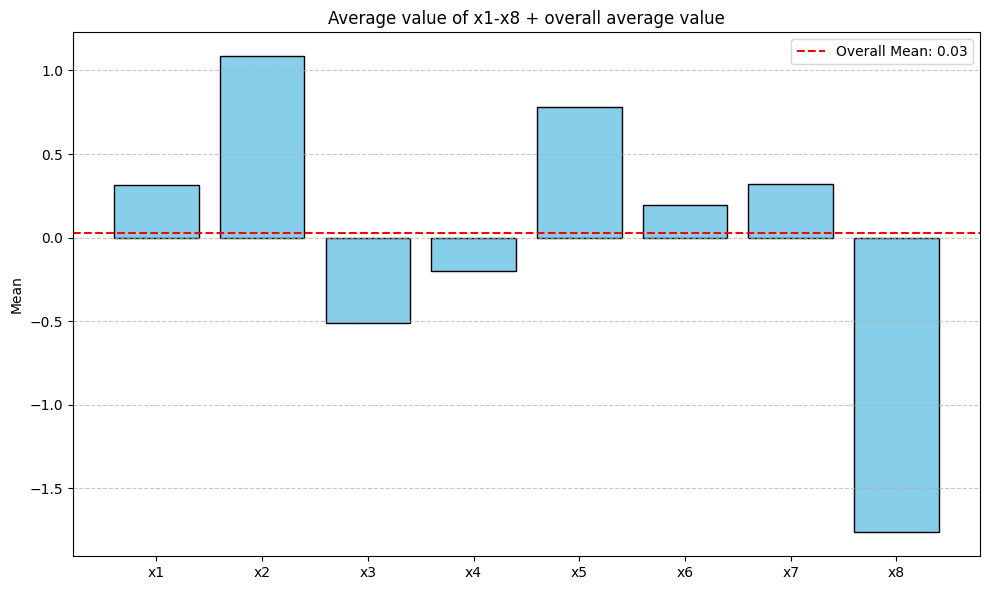

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


means = [x.values.mean() for x in x_list]
overall_mean = np.mean(means)

# Create labels for x-axis
labels = [f'x{i+1}' for i in range(len(x_list))]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(labels, means, color='skyblue', edgecolor='black')
plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')
plt.title('Average value of x1-x8 + overall average value')
plt.ylabel('Mean')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Average value of kurtosis in each sensor

In [ ]:
y1= pd.concat([PS1_stats.kurtosisPS1, PS2_stats.kurtosisPS2, PS3_stats.kurtosisPS3, PS4_stats.kurtosisPS4, PS5_stats.kurtosisPS5, PS6_stats.kurtosisPS6], axis=1)
y2 = pd.concat([EPS1_stats.kurtosisEPS1], axis=1)
y3 = pd.concat([FS1_stats.kurtosisFS1, FS2_stats.kurtosisFS2], axis=1)
y4 = pd.concat([TS1_stats.kurtosisTS1, TS2_stats.kurtosisTS2, TS3_stats.kurtosisTS3, TS4_stats.kurtosisTS4],axis=1)
y5 = pd.concat([VS1_stats.kurtosisVS1],axis=1)
y6 = pd.concat([CE_stats.kurtosisCE],axis=1)
y7 = pd.concat([CP_stats.kurtosisCP],axis=1)
y8 = pd.concat([SE_stats.kurtosisSE],axis=1)

In [ ]:
y1.values.mean() # gia na dw oti ta bgazei swsta

16.94025134016085

In [ ]:
y2.values.mean() # gia na dw oti ta bgazei swsta

0.27057015175599647

In [ ]:
y_list = [y1, y2, y3, y4, y5, y6, y7, y8]  # akrivws ta idia kanw kai me to skewness

for i in range(len(y_list)):
  print(y_list[i].values.mean())

16.94025134016085
0.27057015175599647
1.0440902887424919
-0.3337980021941852
0.4129463699874921
-0.4767727671921494
-0.468285358169515
2.1612803876326603


In [ ]:
means_y = [y.values.mean() for y in y_list]
overall_mean_y = sum(means_y) / len(means_y)
print(overall_mean_y) # overall kurtosis in the system

2.4437853013404554


### Plot of average value of kurtosis

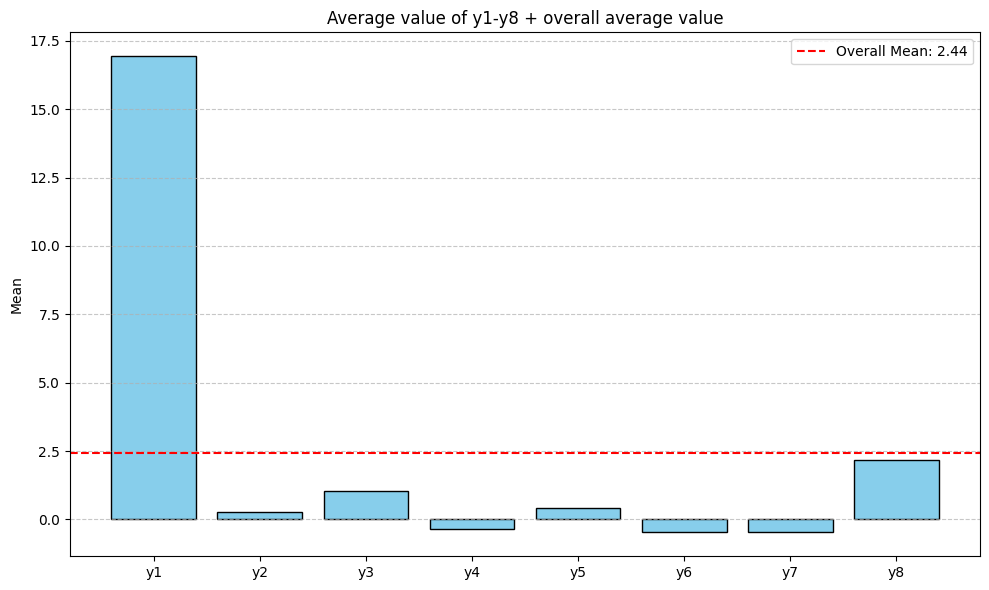

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


means = [y.values.mean() for y in y_list]
overall_mean = np.mean(means)

# Create labels for x-axis
labels = [f'y{i+1}' for i in range(len(y_list))]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(labels, means, color='skyblue', edgecolor='black')
plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')
plt.title('Average value of y1-y8 + overall average value')
plt.ylabel('Mean')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##Compine the data by category

In [ ]:
combined_stats_fs = pd.concat([FS1_stats, FS2_stats], axis=1)
combined_stats_ps = pd.concat([PS1_stats, PS2_stats, PS3_stats, PS4_stats, PS5_stats, PS6_stats], axis=1)
combined_stats_ts = pd.concat([TS1_stats, TS2_stats, TS3_stats, TS4_stats], axis=1)

In [ ]:
combined_stats_ts

,meanTS1,kurtosisTS1,skewnessTS1,stdTS1,minTS1,maxTS1,rangeTS1,rmsTS1,meanTS2,kurtosisTS2,...,rangeTS3,rmsTS3,meanTS4,kurtosisTS4,skewnessTS4,stdTS4,minTS4,maxTS4,rangeTS4,rmsTS4
0,35.621983,-1.345153,0.037994,0.308230,35.156,36.152,0.996,35.623295,40.978767,-1.445545,...,0.297,38.471108,31.745250,-1.407325,0.254104,1.116478,30.363,33.594,3.231,31.764550
1,36.676967,-1.361932,-0.298816,0.585740,35.648,37.488,1.840,36.681566,41.532767,-1.453860,...,0.586,38.979361,34.493867,-1.053366,-0.313176,0.435312,33.648,35.148,1.500,34.496568
2,37.880800,-1.239391,-0.464168,0.559169,36.879,38.621,1.742,37.884858,42.442450,-1.456512,...,0.828,39.632732,35.646150,-1.045293,-0.097014,0.293889,35.098,36.141,1.043,35.647341
3,38.879050,-1.107794,-0.557592,0.516176,37.887,39.473,1.586,38.882419,43.403983,-1.533251,...,0.911,40.404375,36.579467,-1.167018,-0.195165,0.262397,36.105,36.988,0.883,36.580392
4,39.803917,-1.193046,-0.526115,0.535374,38.789,40.391,1.602,39.807457,44.332750,-1.452386,...,0.918,41.311576,37.427900,-1.159541,-0.186079,0.239571,36.992,37.781,0.789,37.428654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,35.313783,-0.709123,-0.746349,0.141893,35.000,35.516,0.516,35.314064,40.874800,-1.494533,...,0.203,38.269323,30.404733,1.705924,1.590891,0.032142,30.363,30.488,0.125,30.404750
2201,35.321600,-0.435753,-0.797022,0.137743,34.988,35.516,0.528,35.321864,40.868883,-1.292374,...,0.270,38.268317,30.416233,-1.024678,0.771821,0.037951,30.367,30.488,0.121,30.416257
2202,35.319183,-0.839548,-0.656237,0.152040,34.984,35.520,0.536,35.319505,40.875950,-1.503629,...,0.215,38.246450,30.426250,-1.517130,0.411465,0.045413,30.367,30.496,0.129,30.426283
2203,35.324767,-0.777044,-0.677971,0.158769,35.000,35.531,0.531,35.325118,40.876067,-1.451841,...,0.218,38.245806,30.414283,-0.301610,1.078721,0.038725,30.363,30.488,0.125,30.414308


##Combine all the data

In [ ]:
combined_data = pd.concat([combined_stats_fs, combined_stats_ps, combined_stats_ts, CE_stats, CP_stats, EPS1_stats, VS1_stats, SE_stats], axis=1)
combined_data

,meanFS1,kurtosisFS1,skewnessFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,kurtosisFS2,...,rangeVS1,rmsVS1,meanSE,kurtosisSE,skewnessSE,stdSE,minSE,maxSE,rangeSE,rmsSE
0,6.709815,1.685735,-1.403308,3.015428,0.0,18.710,18.710,7.355220,10.304592,-1.392848,...,0.092,0.577575,59.157183,2.654072,-2.083248,23.763984,0.0,79.568,79.568,63.677996
1,6.715315,1.661719,-1.450100,3.006248,0.0,18.712,18.712,7.356488,10.403098,-0.366831,...,0.102,0.566494,59.335617,2.635399,-2.074927,23.857918,0.0,80.441,80.441,63.878236
2,6.718522,1.648260,-1.435454,3.014248,0.0,18.698,18.698,7.362682,10.366250,-0.419877,...,0.133,0.577683,59.543150,2.652670,-2.080158,23.923381,0.0,80.824,80.824,64.095055
3,6.720565,1.679665,-1.410198,3.020176,0.0,18.896,18.896,7.366970,10.302678,-0.324455,...,0.118,0.570233,59.794900,2.653043,-2.081369,24.023005,0.0,80.930,80.930,64.365491
4,6.690308,1.643087,-1.426230,3.011550,0.0,18.876,18.876,7.335840,10.237750,-0.746454,...,0.136,0.578321,59.455267,2.576797,-2.051926,23.972262,0.0,81.100,81.100,64.031400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,6.689930,1.940312,-1.390579,3.001512,0.0,20.228,20.228,7.331386,10.184515,-0.145166,...,0.106,0.551627,59.033100,2.725513,-2.109028,23.635352,0.0,77.752,77.752,63.515559
2201,6.692182,1.957889,-1.383932,3.005831,0.0,20.308,20.308,7.335206,10.177767,0.488866,...,0.077,0.547897,59.068000,2.735729,-2.112684,23.638396,0.0,77.592,77.592,63.549111
2202,6.693277,1.951324,-1.414359,2.991333,0.0,20.071,20.071,7.330287,10.176172,0.232962,...,0.095,0.545755,59.132350,2.765289,-2.122933,23.633405,0.0,77.773,77.773,63.607104
2203,6.684128,1.952499,-1.385890,3.003983,0.0,20.280,20.280,7.327103,10.178353,0.712555,...,0.083,0.537302,58.970800,2.734487,-2.112283,23.600817,0.0,77.568,77.568,63.445019


In [ ]:
# the dataset for scaling
profile_without_first_and_last_columns = profile.iloc[:, 1:-1]
data_for_scalling = pd.concat([combined_data, profile_without_first_and_last_columns], axis=1)
data_for_scalling

,meanFS1,kurtosisFS1,skewnessFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,kurtosisFS2,...,skewnessSE,stdSE,minSE,maxSE,rangeSE,rmsSE,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar
0,6.709815,1.685735,-1.403308,3.015428,0.0,18.710,18.710,7.355220,10.304592,-1.392848,...,-2.083248,23.763984,0.0,79.568,79.568,63.677996,3,100,0,130
1,6.715315,1.661719,-1.450100,3.006248,0.0,18.712,18.712,7.356488,10.403098,-0.366831,...,-2.074927,23.857918,0.0,80.441,80.441,63.878236,3,100,0,130
2,6.718522,1.648260,-1.435454,3.014248,0.0,18.698,18.698,7.362682,10.366250,-0.419877,...,-2.080158,23.923381,0.0,80.824,80.824,64.095055,3,100,0,130
3,6.720565,1.679665,-1.410198,3.020176,0.0,18.896,18.896,7.366970,10.302678,-0.324455,...,-2.081369,24.023005,0.0,80.930,80.930,64.365491,3,100,0,130
4,6.690308,1.643087,-1.426230,3.011550,0.0,18.876,18.876,7.335840,10.237750,-0.746454,...,-2.051926,23.972262,0.0,81.100,81.100,64.031400,3,100,0,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,6.689930,1.940312,-1.390579,3.001512,0.0,20.228,20.228,7.331386,10.184515,-0.145166,...,-2.109028,23.635352,0.0,77.752,77.752,63.515559,100,100,0,90
2201,6.692182,1.957889,-1.383932,3.005831,0.0,20.308,20.308,7.335206,10.177767,0.488866,...,-2.112684,23.638396,0.0,77.592,77.592,63.549111,100,100,0,90
2202,6.693277,1.951324,-1.414359,2.991333,0.0,20.071,20.071,7.330287,10.176172,0.232962,...,-2.122933,23.633405,0.0,77.773,77.773,63.607104,100,100,0,90
2203,6.684128,1.952499,-1.385890,3.003983,0.0,20.280,20.280,7.327103,10.178353,0.712555,...,-2.112283,23.600817,0.0,77.568,77.568,63.445019,100,100,0,90


##Scaling the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(data_for_scalling)
scaled_data_dtset = pd.DataFrame(scaled_data, columns=data_for_scalling.columns) # Just a columns argument needed
scaled_data_dtset

,meanFS1,kurtosisFS1,skewnessFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,kurtosisFS2,...,skewnessSE,stdSE,minSE,maxSE,rangeSE,rmsSE,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar
0,0.997260,0.251219,0.024081,0.324744,0.0,0.006738,0.006738,0.994415,0.936266,0.021064,...,0.014625,0.300522,0.0,0.403872,0.403872,0.955790,0.0,1.0,0.0,1.0
1,0.998429,0.248246,0.012408,0.316215,0.0,0.007861,0.007861,0.994729,1.000000,0.306661,...,0.016764,0.309175,0.0,0.428616,0.428616,0.961061,0.0,1.0,0.0,1.0
2,0.999110,0.246580,0.016062,0.323648,0.0,0.000000,0.000000,0.996267,0.976159,0.291895,...,0.015419,0.315204,0.0,0.439472,0.439472,0.966769,0.0,1.0,0.0,1.0
3,0.999545,0.250468,0.022362,0.329155,0.0,0.111173,0.111173,0.997331,0.935028,0.318456,...,0.015108,0.324381,0.0,0.442476,0.442476,0.973889,0.0,1.0,0.0,1.0
4,0.993113,0.245940,0.018362,0.321141,0.0,0.099944,0.099944,0.989604,0.893019,0.200991,...,0.022678,0.319707,0.0,0.447295,0.447295,0.965093,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.993032,0.282732,0.027256,0.311815,0.0,0.859068,0.859068,0.988499,0.858576,0.368362,...,0.007996,0.288674,0.0,0.352399,0.352399,0.951513,1.0,1.0,0.0,0.0
2201,0.993511,0.284908,0.028914,0.315827,0.0,0.903987,0.903987,0.989447,0.854209,0.544848,...,0.007056,0.288954,0.0,0.347864,0.347864,0.952397,1.0,1.0,0.0,0.0
2202,0.993744,0.284096,0.021324,0.302358,0.0,0.770915,0.770915,0.988226,0.853177,0.473616,...,0.004421,0.288495,0.0,0.352995,0.352995,0.953923,1.0,1.0,0.0,0.0
2203,0.991799,0.284241,0.028426,0.314110,0.0,0.888265,0.888265,0.987436,0.854589,0.607113,...,0.007160,0.285493,0.0,0.347184,0.347184,0.949656,1.0,1.0,0.0,0.0


In [ ]:
profile_last_column = profile.iloc[:, -1]
total_data = pd.concat([scaled_data_dtset, profile_last_column], axis = 1)
total_data

,meanFS1,kurtosisFS1,skewnessFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,kurtosisFS2,...,stdSE,minSE,maxSE,rangeSE,rmsSE,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag
0,0.997260,0.251219,0.024081,0.324744,0.0,0.006738,0.006738,0.994415,0.936266,0.021064,...,0.300522,0.0,0.403872,0.403872,0.955790,0.0,1.0,0.0,1.0,1
1,0.998429,0.248246,0.012408,0.316215,0.0,0.007861,0.007861,0.994729,1.000000,0.306661,...,0.309175,0.0,0.428616,0.428616,0.961061,0.0,1.0,0.0,1.0,1
2,0.999110,0.246580,0.016062,0.323648,0.0,0.000000,0.000000,0.996267,0.976159,0.291895,...,0.315204,0.0,0.439472,0.439472,0.966769,0.0,1.0,0.0,1.0,1
3,0.999545,0.250468,0.022362,0.329155,0.0,0.111173,0.111173,0.997331,0.935028,0.318456,...,0.324381,0.0,0.442476,0.442476,0.973889,0.0,1.0,0.0,1.0,1
4,0.993113,0.245940,0.018362,0.321141,0.0,0.099944,0.099944,0.989604,0.893019,0.200991,...,0.319707,0.0,0.447295,0.447295,0.965093,0.0,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.993032,0.282732,0.027256,0.311815,0.0,0.859068,0.859068,0.988499,0.858576,0.368362,...,0.288674,0.0,0.352399,0.352399,0.951513,1.0,1.0,0.0,0.0,0
2201,0.993511,0.284908,0.028914,0.315827,0.0,0.903987,0.903987,0.989447,0.854209,0.544848,...,0.288954,0.0,0.347864,0.347864,0.952397,1.0,1.0,0.0,0.0,0
2202,0.993744,0.284096,0.021324,0.302358,0.0,0.770915,0.770915,0.988226,0.853177,0.473616,...,0.288495,0.0,0.352995,0.352995,0.953923,1.0,1.0,0.0,0.0,0
2203,0.991799,0.284241,0.028426,0.314110,0.0,0.888265,0.888265,0.987436,0.854589,0.607113,...,0.285493,0.0,0.347184,0.347184,0.949656,1.0,1.0,0.0,0.0,0
